Chemiscope Auto
==========================================

This example performs dimensionality reduction and visualization analysis on
molecular data from the QM9 dataset using techniques such as PCA, UMAP, t-SNE,
and ICA. It calculates features like MACE-OFF, MACE-MP, and SOAP for the
molecular structures, then applies dimensionality reduction methods to explore
their intrinsic structures.

First, import the necessary packages:

In [2]:
import os
import time

import chemiscope
import matplotlib.pyplot as plt
import numpy as np
import umap
from load_atoms import load_dataset
from mace.calculators import mace_mp, mace_off
from metatensor import mean_over_samples
from rascaline.calculators import SoapPowerSpectrum
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

Load `QM9`_ dataset and select the first 20 structures.

In [3]:
frames = load_dataset("QM9")
frames20 = frames[:20]

Output()

Define the dimensionality reduction techniques to be used.

In [4]:
methods = ["PCA", "UMAP", "TSNE", "ICA"]

Let's define a function to perform dimensionality reduction using specified methods. It takes as input a set of descriptors and the name of the dimensionality reduction method to use. It returns the reduced data and the execution time for the reduction process.

In [5]:
def dimensionality_reduction_analysis(descriptors, method="PCA"):
    if method not in methods:
        raise ValueError("Invalid method name.")

    # Record the start time for measuring execution duration
    start_time = time.time()

    # Initialize the reducer based on the specified method
    if method == "PCA":
        reducer = PCA(n_components=2)

    elif method == "UMAP":
        reducer = umap.UMAP(
            n_components=2,  # reduce to 2 dimensions
            n_neighbors=15,  # number of neighbors to consider
            min_dist=0.1,  # minimum distance between points
            metric="euclidean",  # distance metric
            target_metric="categorical",  # metric for the target space
        )

    elif method == "TSNE":
        perplexity = min(30, descriptors.shape[0] - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity)

    elif method == "ICA":
        reducer = FastICA(n_components=2)

    # Apply the dimensionality reduction to the descriptors
    X_reduced = reducer.fit_transform(descriptors)

    # Calculate the execution time
    execution_time = time.time() - start_time
    print(f"{method} execution time: {execution_time:.2f} seconds")

    return X_reduced, execution_time

#### Compute structural descriptors
This section calculates features that describe the structure of molecules in the frames data.

In [6]:
# At first, initialise the calculatorsf for MACE-OFF and MACE-MP.

descriptor_opt = {"model": "small", "device": "cpu", "default_dtype": "float64"}
calculator_mace_off = mace_off(**descriptor_opt)
calculator_mace_mp = mace_mp(**descriptor_opt)

Using MACE-OFF23 MODEL for MACECalculator with /home/chorna/.cache/mace/MACE-OFF23_small.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/chorna/.cache/mace/46jrkm3v
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


Here we define a function to compute MACE features. This function takes a list of frames (molecules) and a MACE calculator as input.
It iterates through each frame, calculates the MACE descriptors, and then computes the average descriptor value across all atoms in the frame. Finally, it returns these average descriptors for all frames in a numpy array.

In [7]:
def compute_mace_features(frames, calculator, invariants_only=False):
    descriptors = []
    for frame in tqdm(frames):
        structure_avg = np.mean(
            (calculator.get_descriptors(frame, invariants_only=invariants_only)),
            axis=0,
        )
        descriptors.append(structure_avg)
    return np.array(descriptors)

Compute MACE MP and MACE OFF descriptors.

In [8]:
mace_mp_features = compute_mace_features(frames20, calculator_mace_mp)
mace_off_features = compute_mace_features(frames20, calculator_mace_off)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Here we set up a SOAP calculator to compute another type of structural descriptor called SOAP features.
We define a dictionary containing hyperparameters for the SOAP calculator for evaluating rascaline features.

In [9]:
hypers = {
    "cutoff": 4,
    "max_radial": 6,
    "max_angular": 4,
    "atomic_gaussian_width": 0.7,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto": {"accuracy": 1e-6}},
    "center_atom_weight": 1.0,
}
calculator_soap = SoapPowerSpectrum(**hypers)

Let's use a function to compute SOAP features for the given frames.

In [10]:
def compute_soap_features(frames, calculator):
    reducer = calculator.compute(frames)

    # Extract SOAP features at the atom level
    atom_soap_single_block = reducer.keys_to_samples(["center_type"])

    # Group them by atom and its surrounding neighbors
    atom_soap_grouped = atom_soap_single_block.keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )

    # Aggregate over frames and atom types
    aggregated_features = mean_over_samples(
        atom_soap_grouped, sample_names=["atom", "center_type"]
    )

    # Extract the values from the resulting tensor block
    return aggregated_features.block(0).values

Compute SOAP descriptors.

In [11]:
soap_features = compute_soap_features(frames20, calculator_soap)

#### Dimensionality Reduction and Visualization of Descriptors
In this section we perform dimensionality reduction on the computed descriptors (MACE-OFF, MACE-MP, and SOAP) and visualize the results.

In [12]:
descriptors = [mace_off_features, mace_mp_features, soap_features]
descriptor_names = ["MACE OFF", "MACE MP", "SOAP"]

Create a grid of subplots with the results for each descriptor and method.

MACE OFF
PCA execution time: 0.00 seconds
UMAP execution time: 4.03 seconds
TSNE execution time: 0.08 seconds
ICA execution time: 0.00 seconds

MACE MP
PCA execution time: 0.00 seconds
UMAP execution time: 1.15 seconds
TSNE execution time: 0.07 seconds
ICA execution time: 0.00 seconds

SOAP
PCA execution time: 0.00 seconds
UMAP execution time: 1.15 seconds
TSNE execution time: 0.07 seconds
ICA execution time: 0.00 seconds



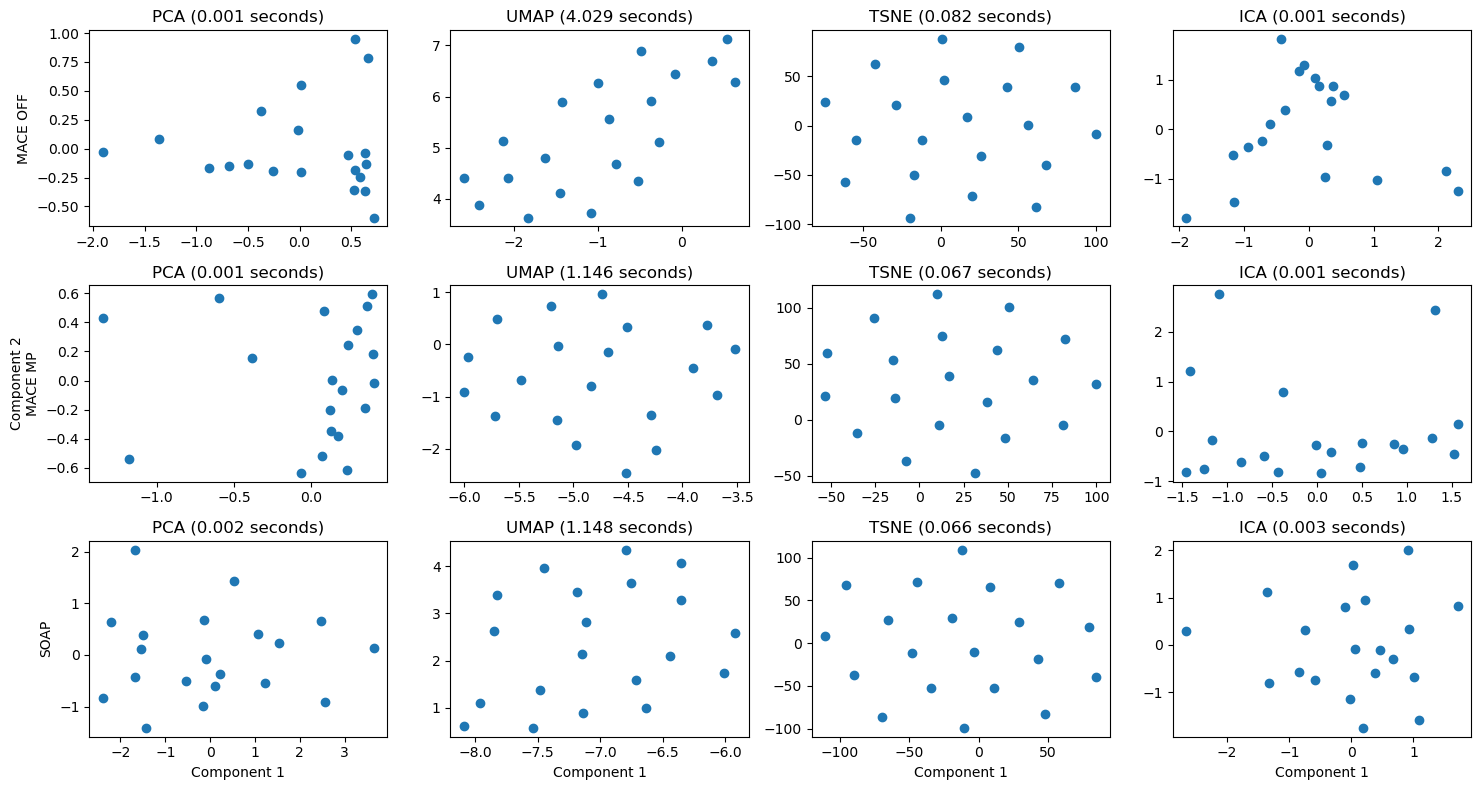

In [13]:
fig, axes = plt.subplots(len(descriptors), len(methods), figsize=(15, 8))

for i, descriptor in enumerate(descriptors):
    descriptor_name = descriptor_names[i]
    print(descriptor_name)

    for j, method in enumerate(methods):
        ax = axes[i, j]
        X_reduced, execution_time = dimensionality_reduction_analysis(
            descriptor, method
        )

        ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
        ax.set_title(f"{method} ({execution_time:.3f} seconds)")
        if i == len(descriptors) - 1:  # Last row
            ax.set_xlabel("Component 1")
        if j == 0:
            if i == 1:
                ax.set_ylabel(f"Component 2\n{descriptor_name}")
            else:
                ax.set_ylabel(descriptor_name)

    print("")

plt.tight_layout()
plt.show()

#### Dimensionality Reduction on Combined Features
This section explores dimensionality reduction after combining all the previously computed features into a single dataset. This combined dataset might capture a broader representation of the data, and dimensionality reduction can help visualize potential relationships between data points in a lower-dimensional space.


In [14]:
concatenated_features = np.concatenate(
    (mace_off_features, mace_mp_features, soap_features), axis=1
)

Let's also create a subplot to visualize the dimensionality reduction results.

PCA execution time: 0.00 seconds
UMAP execution time: 1.97 seconds
TSNE execution time: 0.05 seconds
ICA execution time: 0.00 seconds


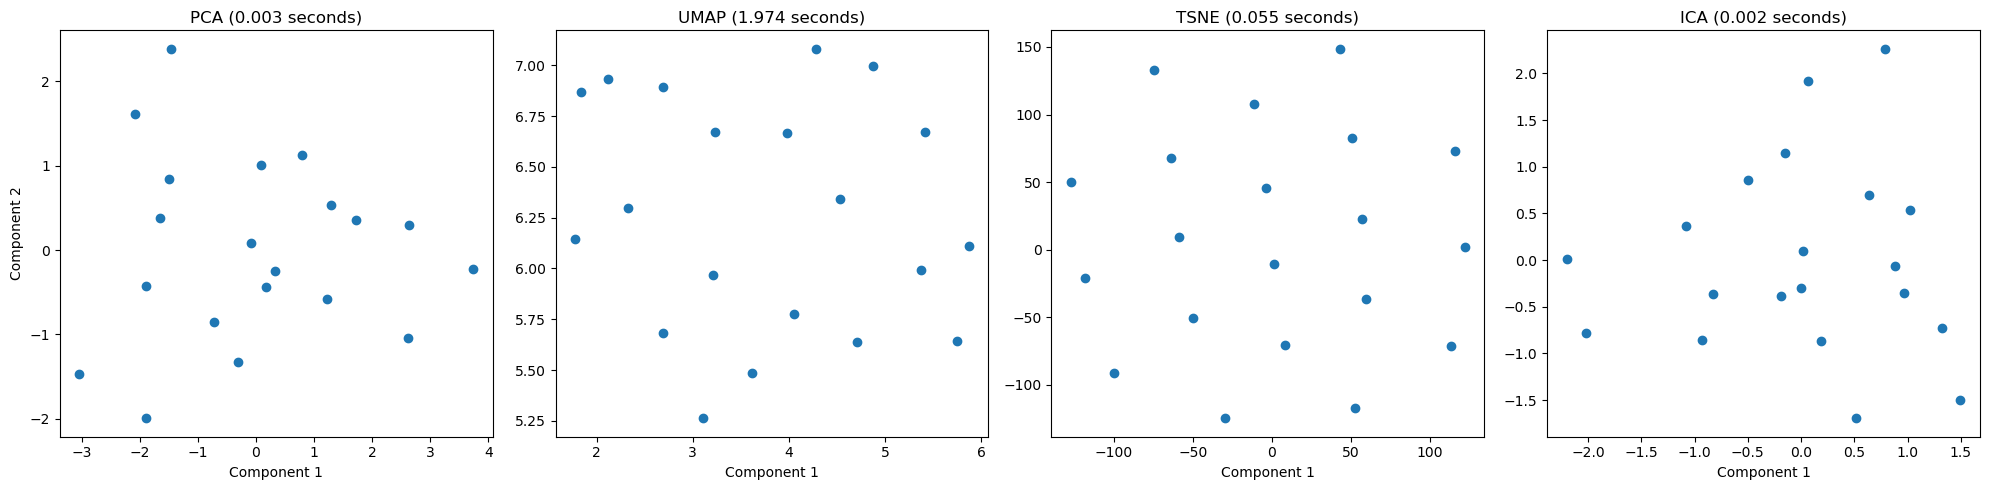

In [15]:
fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))

for j, method in enumerate(methods):
    ax = axes[j]
    X_reduced, execution_time = dimensionality_reduction_analysis(
        concatenated_features, method
    )
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
    ax.set_title(f"{method} ({execution_time:.3f} seconds)")
    ax.set_xlabel("Component 1")
    if j == 0:
        ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

#### Visualization of Precomputed Descriptors
In this section we visualise the precomputed dimensionality reduction results for the whole dataset.

Loading precomputed reduced data for PCA...
Loading precomputed reduced data for UMAP...
Loading precomputed reduced data for TSNE...
Loading precomputed reduced data for ICA...
Loading precomputed reduced data for PCA...
Loading precomputed reduced data for UMAP...
Loading precomputed reduced data for TSNE...
Loading precomputed reduced data for ICA...


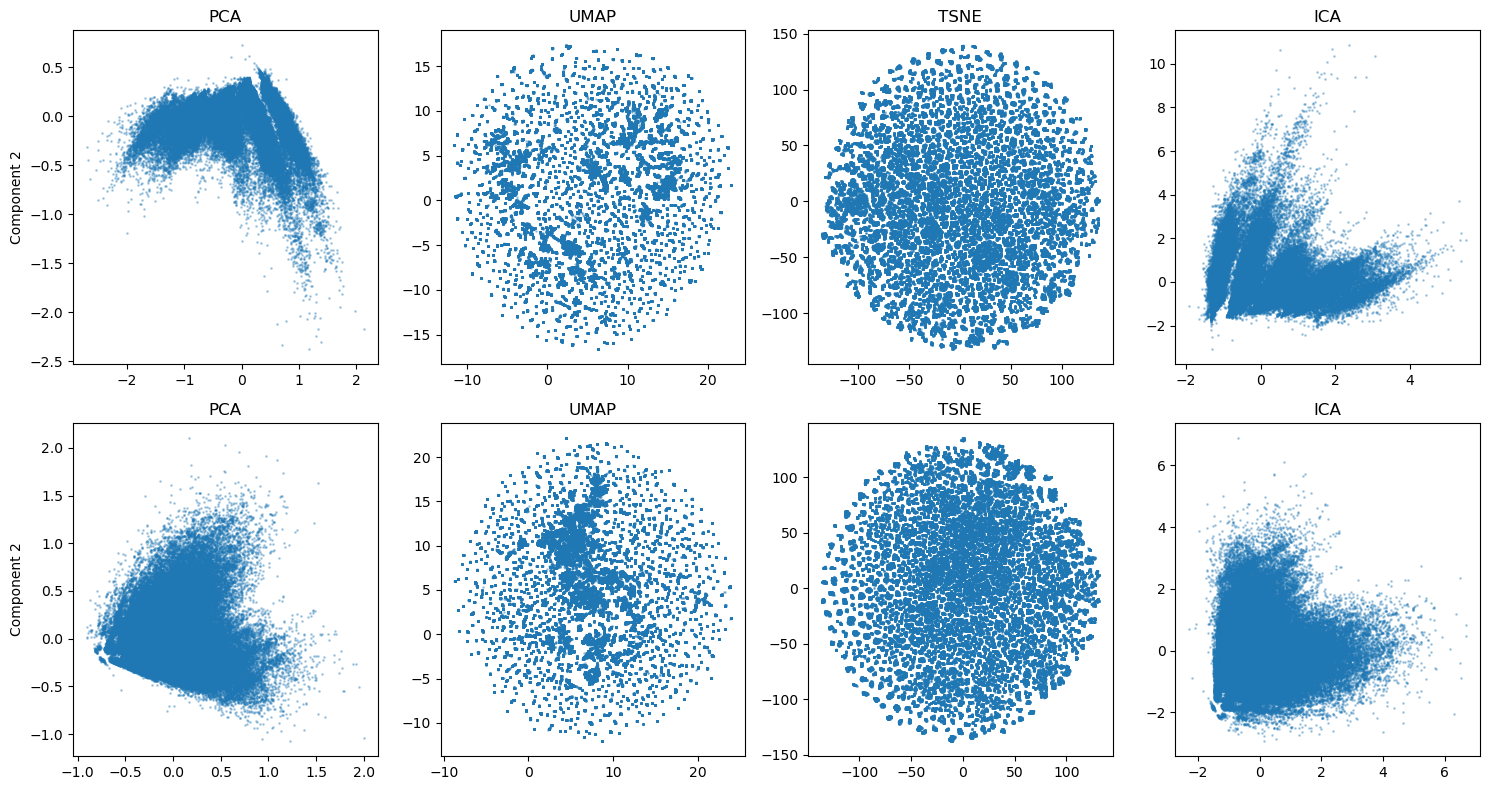

In [16]:
reduced_points = {}

# descriptor_names = ["mace_off", "mace_mp", "soap"]
descriptor_names = ["mace_off", "mace_mp"]

fig, axes = plt.subplots(len(descriptor_names), len(methods), figsize=(15, 8))

for i, descriptor_name in enumerate(descriptor_names):
    for j, method in enumerate(methods):
        ax = axes[i, j]

        # Load precomputed data points for this descriptor and method
        print(f"Loading precomputed reduced data for {method}...")
        name = f"{method}_{descriptor_name}"
        points_path = os.path.join("data", f"{name}_points.npy")
        X_reduced = np.load(points_path)

        # Save to the object to use later
        reduced_points[name] = X_reduced

        # Scatter plot
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3, s=1)
        ax.set_title(method)
        if i == len(descriptors) - 1:  # Last row
            ax.set_xlabel("Component 1")
        if j == 0:
            ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

#### Chemiscope visualization
Finally, we use Chemiscope, a visualization tool for exploring relationships between molecular structures and their properties.
We will extract relevant properties from the data and then use Chemiscope to create an interactive structure-property map.

Let's use the 10% of the dataset to visulise it.

In [17]:
_train, test = frames.random_split([0.9, 0.1])

Extract properties except "frequencies".

In [18]:
props_keys = test[0].info.keys()
structural_properties = chemiscope.extract_properties(
    test, only={key for key in props_keys if key != "frequencies"}
)

Load the interactive chemisope widget.

In [19]:
cs = chemiscope.show(test, structural_properties

<ChemiscopeWidget(meta={'name': 'QM9 Properties'}, structures=[{'size': 19, 'names': ['C', 'C', 'C', 'C', 'C',…

In [ ]:
, meta={"name": "QM9 Properties"})
cs

Prepare properties dictionary for chemiscope visualization.

In [20]:
props = {}
for prop, value in reduced_points.items():
    props[f"{prop} 1"] = value[:, 0].tolist()
    props[f"{prop} 2"] = value[:, 1].tolist()

Create a chemiscope widget.

In [21]:
cs = chemiscope.show(
    frames=frames,
    properties=props,
    meta={"name": "QM9 features"},
)
cs

<ChemiscopeWidget(meta={'name': 'QM9 features'}, structures=[{'size': 5, 'names': ['C', 'H', 'H', 'H', 'H'], '…